### Data read and analyse synaptic vesicle clusters from ImageJ output

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from __future__ import generators
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import glob
from PIL import Image
import skimage.morphology
from skimage import measure, morphology
from math import sqrt

In [2]:
def compute_MSD(xdata,ydata):
    # for dt=frametime
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    diff = np.sqrt(np.power(np.diff(xdata),2) + np.power(np.diff(ydata),2))
    msd = np.mean(diff)
    return msd

def compute_MSD_time(xdata,ydata):
    # for dt=[frametime,timelapsetime]
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    msd_time = []
    for i in range(len(xdata)):
        if i < 1:
            msd_time.append(0)
        else:
            xdata_shift = np.roll(xdata,i)[i:-i]
            ydata_shift = np.roll(ydata,i)[i:-i]
            xdata_stat = xdata[i:-i]
            ydata_stat = ydata[i:-i]
            diff = np.sqrt(np.power(xdata_shift-xdata_stat,2) + np.power(ydata_shift-ydata_stat,2))
            msd = np.mean(diff)
            msd_time.append(msd)
    return msd_time


# from: https://gist.github.com/VolkerH/0d07d05d5cb189b56362e8ee41882abf

def orientation(p,q,r):
    '''Return positive if p-q-r are clockwise, neg if ccw, zero if colinear.'''
    return (q[1]-p[1])*(r[0]-p[0]) - (q[0]-p[0])*(r[1]-p[1])

def hulls(Points):
    '''Graham scan to find upper and lower convex hulls of a set of 2d points.'''
    U = []
    L = []
    Points.sort()
    for p in Points:
        while len(U) > 1 and orientation(U[-2],U[-1],p) <= 0: U.pop()
        while len(L) > 1 and orientation(L[-2],L[-1],p) >= 0: L.pop()
        U.append(p)
        L.append(p)
    return U,L

def rotatingCalipers(Points):
    '''Given a list of 2d points, finds all ways of sandwiching the points
between two parallel lines that touch one point each, and yields the sequence
of pairs of points touched by each pair of lines.'''
    U,L = hulls(Points)
    i = 0
    j = len(L) - 1
    while i < len(U) - 1 or j > 0:
        yield U[i],L[j]
        
        # if all the way through one side of hull, advance the other side
        if i == len(U) - 1: j -= 1
        elif j == 0: i += 1
        
        # still points left on both lists, compare slopes of next hull edges
        # being careful to avoid divide-by-zero in slope calculation
        elif (U[i+1][1]-U[i][1])*(L[j][0]-L[j-1][0]) > \
                (L[j][1]-L[j-1][1])*(U[i+1][0]-U[i][0]):
            i += 1
        else: j -= 1


def min_max_feret(Points):
    '''Given a list of 2d points, returns the minimum and maximum feret diameters.'''
    squared_distance_per_pair = [((p[0]-q[0])**2 + (p[1]-q[1])**2, (p,q))
                     for p,q in rotatingCalipers(Points)]
    min_feret_sq, min_feret_pair = min(squared_distance_per_pair)
    max_feret_sq, max_feret_pair = max(squared_distance_per_pair)
    return sqrt(min_feret_sq), sqrt(max_feret_sq)


def diameter(Points):
    '''Given a list of 2d points, returns the pair that's farthest apart.'''
    diam,pair = max([((p[0]-q[0])**2 + (p[1]-q[1])**2, (p,q))
                     for p,q in rotatingCalipers(Points)])
    return diam, pair

def min_feret(Points):
    '''Given a list of 2d points, returns the pair that's farthest apart.'''
    min_feret_sq,pair = min([((p[0]-q[0])**2 + (p[1]-q[1])**2, (p,q))
                     for p,q in rotatingCalipers(Points)])
    return min_feret_sq, pair

def get_min_max_feret_from_mask(mask_im):
    """ given a binary mask, calculate the minimum and maximum
    feret diameter of the foreground object. This is done
    by calculating the outline of the object, transform
    the pixel coordinates of the outline into a list of
    points and then calling 
    Parameters:
        mask_im: binary numpy array
    """
    eroded = skimage.morphology.erosion(mask_im)
    outline = mask_im ^ eroded
    boundary_points = np.argwhere(outline > 0)
    # convert numpy array to a list of (x,y) tuple points
    boundary_point_list = list(map(list, list(boundary_points)))
    return min_max_feret(boundary_point_list)

def walklevel(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
        yield root, dirs, files
        num_sep_this = root.count(os.path.sep)
        if num_sep + level <= num_sep_this:
            del dirs[:]

In [3]:
file = 'GlobalResult.txt'
d_th = 0.3

['D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell003\\001', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell003\\002', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell003\\003', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell003\\004', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell003\\005', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell003\\006', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell004\\001', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell004\\002', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell004\\003', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell004\\004', 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz\\sample1\\cell004\\005', 'D:\\Data analysis\\etsted\\data\\old\\syt

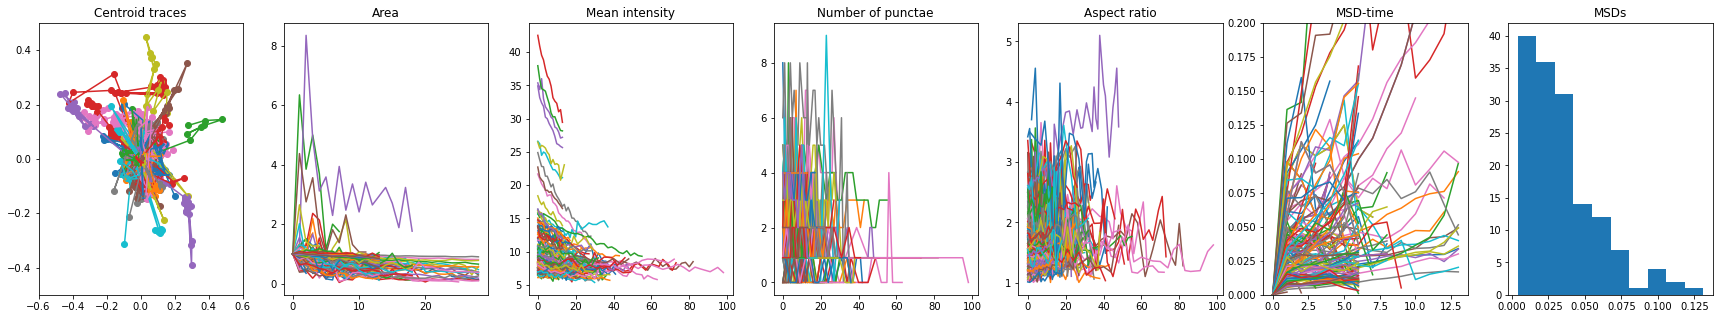

In [6]:
mode = 'fast-24hz'
if mode == 'fast':
    folder_master = 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\'
    folder_depth = 9
    dt = 0.042  #s
elif mode == 'fast-24hz':
    folder_master = 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\24Hz'
    folder_depth = 10
    dt = 0.042  #s
elif mode == 'fast-11hz':
    folder_master = 'D:\\Data analysis\\etsted\\data\\old\\syt1-fast\\BAPTA\\11Hz'
    folder_depth = 10
    dt = 0.091  #s
elif mode == 'ex':
    folder_master = 'example_data\\catriggered'
    folder_depth = 2
    dt = 0.407  #s
folders = [x[0] for x in walklevel(folder_master,3)]
folders = [x for x in folders if x.count(os.path.sep) == folder_depth]
print(folders)

msds_ca = []
msds_time_ca = []
mean_areas_ca = []
mean_ars_ca = []
f0_areas_ca = []
f0_ars_ca = []
f0_ints_ca = []

area_curves_ca = []
ar_curves_ca = []

fer_rats_ca = []

fig, axs = plt.subplots(1,7,figsize=[30,5])
axs[0].set_xlim([-0.6,0.6]),axs[0].set_ylim([-0.5,0.5])
axs[5].set_ylim([0,0.2])

for folder in folders:
    print(folder, end='\r')
    data = pd.read_csv(os.path.join(folder,file), delimiter='\t')
    data['nf_cc'] = np.nan
    #data

    t_max = np.max(data['time'])
    if t_max is not np.nan:
        for time1 in range(1,t_max):
            data_time1 = data[data['time']==time1]
            data_time2 = data[data['time']==time1+1]
            n_clusters1 = np.max(data_time1['cluster'])
            n_clusters2 = np.max(data_time2['cluster'])
            if n_clusters1 is not np.nan and n_clusters2 is not np.nan:
                for cluster1 in range(n_clusters1+1):
                    #print(cluster1)
                    data_cluster1 = data_time1[data_time1['cluster']==cluster1]
                    x1 = float(data_cluster1['x0'])
                    y1 = float(data_cluster1['y0'])
                    d_min = d_th
                    cluster_conn = [-1,-1]
                    for cluster2 in range(n_clusters2+1):
                        data_cluster2 = data_time2[data_time2['cluster']==cluster2]
                        #print(cluster1,cluster2)
                        x2 = float(data_cluster2['x0'])
                        y2 = float(data_cluster2['y0'])
                        d = np.sqrt((x2-x1)**2+(y2-y1)**2)
                        #print(cluster1,cluster2,d)
                        if d < d_min:
                            d_min = d
                            cluster_conn = [cluster1,cluster2]
                    if d_min < d_th:
                        #print(time1,cluster_conn)
                        data.loc[(data.time == time1) & (data.cluster == cluster1), 'nf_cc'] = cluster_conn[1]
                        #print(cluster_conn,d_min)

        first_tp = np.min(data.loc[data.Area != 0].time.to_numpy())
        clusters = range(0,np.max(data.loc[data.time==first_tp].cluster))
        # find maximum area cluster in this roi
        area_max = 0
        cl_max = 0
        for cluster_init in clusters:
            t_max = np.max(data['time'])
            #cluster_init = 0
            cluster = cluster_init
            area = float(data.loc[(data.time == 1) & (data.cluster == cluster)].Area.to_numpy())
            if area > area_max:
                area_max = area
                cl_max = cluster
        # get info only for biggest cluster
        cluster = cl_max
        rows = []
        for time in range(1,t_max):
            if time in data.time.to_numpy():
                rows.append(data.loc[(data.time == time) & (data.cluster == cluster)].index.to_numpy()[0])
                try:
                    cluster = int(data[(data.time == time) & (data.cluster == cluster)].nf_cc)
                except:
                    break
        data_trace = data.iloc[rows]

        if len(data_trace)>2:
            xdata = []
            ydata = []
            for t in range(1,len(data_trace)):
                xdata.append(float(data_trace[data_trace.time==t].x0.to_numpy()))
                ydata.append(float(data_trace[data_trace.time==t].y0.to_numpy()))
            msd = compute_MSD(xdata,ydata)
            msd_time = np.array(compute_MSD_time(xdata,ydata))
            msds_ca.append(msd)
            msds_time_ca.append(msd_time)
        else:
            msds_ca.append(np.nan)
            msds_time_ca.append(np.array([np.nan]))

        # calculate feret_ratio
        fer_rat = []
        t_max = np.max(data['time'])
        for i in range(1,t_max+1):
            imname = f'cluster_bin{i}.tif'
            im = np.array(Image.open(os.path.join(folder,imname)))
            mask = im > 128

            # assuming mask is a binary image
            # label and calculate parameters for every cluster in mask
            labelled = measure.label(mask)
            rp = measure.regionprops(labelled)

            if not rp == []:
                # get size of largest cluster
                size = max([i.area for i in rp])

                mask_clean = skimage.morphology.remove_small_objects(mask,min_size=size-1)
                try:
                    fer_min,fer_max = get_min_max_feret_from_mask(mask_clean)
                    #print(i,fer_max*0.03,fer_min*0.03)
                    fer_rat.append(fer_max/fer_min)
                except:
                    fer_rat.append(np.nan)
            else:
                fer_rat.append(np.nan)
        fer_rat_std = np.nanstd(fer_rat)
        fer_rats_ca.append(fer_rat_std)
            
        # calculate temporal means of parameters
        mean_areas_ca.append(np.mean(data_trace.Area.to_numpy()))
        mean_ars_ca.append(np.mean(data_trace.major/data_trace.minor))
        
        # extract f0 parameters
        if len(data_trace) > 0:
            f0_areas_ca.append(data_trace.Area.to_numpy()[0])
            f0_ars_ca.append(data_trace.major.to_numpy()[0] / data_trace.minor.to_numpy()[0])
            f0_ints_ca.append(data_trace.MeanIntensity.to_numpy()[0])

            # save area and ar - temporal curve
            area_curves_ca.append(data_trace.Area.to_numpy())
            ar_curves_ca.append((data_trace.major/data_trace.minor).to_numpy())
            
            x_trace = data_trace.x0.to_numpy() - data_trace.x0.to_numpy()[0]
            y_trace = data_trace.y0.to_numpy() - data_trace.y0.to_numpy()[0]
            axs[0].scatter(x_trace,y_trace)
            axs[0].plot(x_trace,y_trace)
            axs[1].plot(data_trace.Area.to_numpy() / data_trace.Area.to_numpy()[0])
            axs[2].plot(data_trace.MeanIntensity)
            axs[3].plot(data_trace.NumPuncta*1000)
            axs[4].plot(data_trace.major/data_trace.minor)
            axs[5].plot(msd_time)

axs[0].title.set_text('Centroid traces')
axs[1].title.set_text('Area')
axs[2].title.set_text('Mean intensity')
axs[3].title.set_text('Number of punctae')
axs[4].title.set_text('Aspect ratio')
axs[5].title.set_text('MSD-time')

msds_ca = np.array(msds_ca)
print(f'MSD: {np.mean(msds_ca[~np.isnan(msds_ca)]):.5f} +- {np.std(msds_ca[~np.isnan(msds_ca)]):.5f}')
print(f'Temporal mean area: {np.mean(mean_areas_ca):.3f} +- {np.std(mean_areas_ca):.3f}')
print(f'Temporal mean AR: {np.mean(mean_ars_ca):.3f} +- {np.std(mean_ars_ca):.3f}')
print(f'F0 area: {np.mean(f0_areas_ca):.3f} +- {np.std(f0_areas_ca):.3f}')
print(f'F0 AR: {np.mean(f0_ars_ca):.3f} +- {np.std(f0_ars_ca):.3f}')
print(f'F0 intensity: {np.mean(f0_ints_ca):.3f} +- {np.std(f0_ints_ca):.3f}')

axs[6].hist(msds_ca)#, bins=range(0,0.2,0.01))
axs[6].title.set_text('MSDs')

['D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\sample1\\001', 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\sample1\\002', 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\sample1\\003', 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\sample1\\004', 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\sample1\\005', 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\sample1\\006', 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\

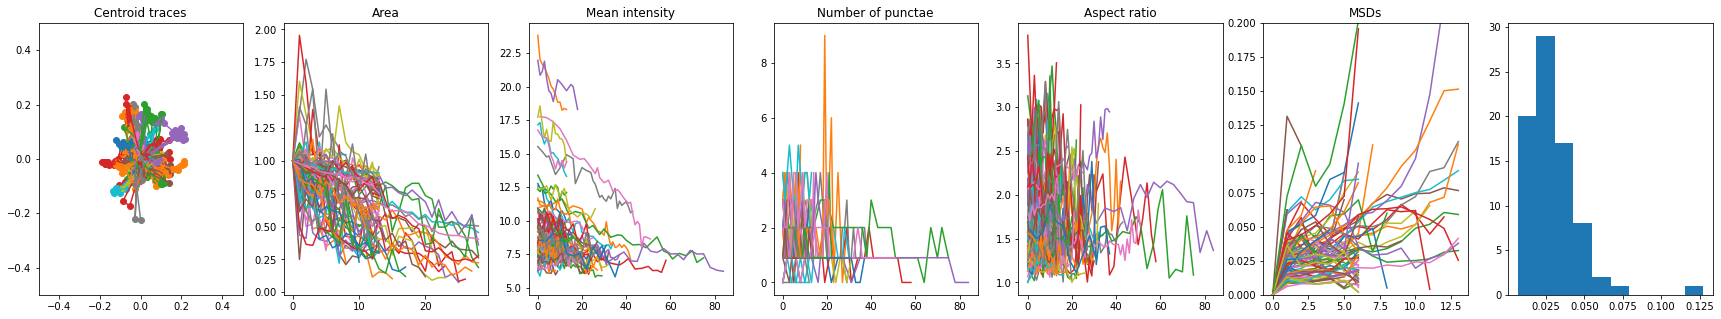

In [12]:
if mode == 'fast':
    folder_master = 'D:\\Data analysis\\etsted\\data\\syt1-fast\\random\\'
    folder_depth = 8
    dt = 0.042  #s
elif mode == 'fast-24hz':
    #folder_master = 'D:\\Data analysis\\etsted\\data\\syt1-fast\\random\\24Hz'
    folder_master = 'D:\\KTH\\OneDrive - KTH\\Manuscripts\\EventTriggeredSTED_manuscript\\application_data\\all\\syt1-fast-220318\\24hz-random\\boutons\\'
    folder_depth = 11
    dt = 0.042  #s
elif mode == 'fast-11hz':
    folder_master = 'D:\\Data analysis\\etsted\\data\\syt1-fast\\random\\11Hz'
    folder_depth = 8
    dt = 0.091  #s
elif mode == 'ex':
    folder_master = 'example_data\\control'
    folder_depth = 2
    dt = 0.407  #s
folders = [x[0] for x in walklevel(folder_master,3)]
folders = [x for x in folders if x.count(os.path.sep) == folder_depth]
print(folders)

msds_ctrl = []
msds_time_ctrl = []
mean_areas_ctrl = []
mean_ars_ctrl = []
f0_areas_ctrl = []
f0_ars_ctrl = []
f0_ints_ctrl = []

area_curves_ctrl = []
ar_curves_ctrl = []

fer_rats_ctrl = []

fig, axs = plt.subplots(1,7,figsize=[30,5])
axs[0].set_xlim([-0.5,0.5]),axs[0].set_ylim([-0.5,0.5])
axs[5].set_ylim([0,0.2])

for folder in folders:
    print(folder, end='\r')
    data = pd.read_csv(os.path.join(folder,file), delimiter='\t')
    data['nf_cc'] = np.nan
    #data
    
    t_max = np.max(data['time'])
    if t_max is not np.nan:
        for time1 in range(1,t_max):
            data_time1 = data[data['time']==time1]
            data_time2 = data[data['time']==time1+1]
            n_clusters1 = np.max(data_time1['cluster'])
            n_clusters2 = np.max(data_time2['cluster'])
            if n_clusters1 is not np.nan and n_clusters2 is not np.nan:
                for cluster1 in range(n_clusters1+1):
                    #print(cluster1)
                    data_cluster1 = data_time1[data_time1['cluster']==cluster1]
                    x1 = float(data_cluster1['x0'])
                    y1 = float(data_cluster1['y0'])
                    d_min = d_th
                    cluster_conn = [-1,-1]
                    for cluster2 in range(n_clusters2+1):
                        data_cluster2 = data_time2[data_time2['cluster']==cluster2]
                        #print(cluster1,cluster2)
                        x2 = float(data_cluster2['x0'])
                        y2 = float(data_cluster2['y0'])
                        d = np.sqrt((x2-x1)**2+(y2-y1)**2)
                        #print(cluster1,cluster2,d)
                        if d < d_min:
                            d_min = d
                            cluster_conn = [cluster1,cluster2]
                    if d_min < d_th:
                        #print(time1,cluster_conn)
                        data.loc[(data.time == time1) & (data.cluster == cluster1), 'nf_cc'] = cluster_conn[1]
                        #print(cluster_conn,d_min)

        first_tp = np.min(data.loc[data.Area != 0].time.to_numpy())
        clusters = range(0,np.max(data.loc[data.time==first_tp].cluster))
        # find maximum area cluster in this roi
        area_max = 0
        cl_max = 0
        for cluster_init in clusters:
            t_max = np.max(data['time'])
            #cluster_init = 0
            cluster = cluster_init
            area = float(data.loc[(data.time == 1) & (data.cluster == cluster)].Area.to_numpy())
            if area > area_max:
                area_max = area
                cl_max = cluster
        # get info only for biggest cluster
        cluster = cl_max
        rows = []
        for time in range(1,t_max):
            if time in data.time.to_numpy():
                rows.append(data.loc[(data.time == time) & (data.cluster == cluster)].index.to_numpy()[0])
                try:
                    cluster = int(data[(data.time == time) & (data.cluster == cluster)].nf_cc)
                except:
                    break
        data_trace = data.iloc[rows]

        if len(data_trace)>2:
            xdata = []
            ydata = []
            for t in range(1,len(data_trace)):
                xdata.append(float(data_trace[data_trace.time==t].x0.to_numpy()))
                ydata.append(float(data_trace[data_trace.time==t].y0.to_numpy()))
            msd = compute_MSD(xdata,ydata)
            msd_time = np.array(compute_MSD_time(xdata,ydata))
            msds_ctrl.append(msd)
            msds_time_ctrl.append(msd_time)
        else:
            msds_ctrl.append(np.nan)
            msds_time_ctrl.append(np.array([np.nan]))

        # calculate feret_ratio
        fer_rat = []
        t_max = np.max(data['time'])
        for i in range(1,t_max+1):
            imname = f'cluster_bin{i}.tif'
            im = np.array(Image.open(os.path.join(folder,imname)))
            mask = im > 128

            # assuming mask is a binary image
            # label and calculate parameters for every cluster in mask
            labelled = measure.label(mask)
            rp = measure.regionprops(labelled)

            if not rp == []:
                # get size of largest cluster
                size = max([i.area for i in rp])

                mask_clean = skimage.morphology.remove_small_objects(mask,min_size=size-1)
                try:
                    fer_min,fer_max = get_min_max_feret_from_mask(mask_clean)
                    #print(i,fer_max*0.03,fer_min*0.03)
                    fer_rat.append(fer_max/fer_min)
                except:
                    fer_rat.append(np.nan)
            else:
                fer_rat.append(np.nan)
        fer_rat_std = np.nanstd(fer_rat)
        fer_rats_ctrl.append(fer_rat_std)
            
        # calculate temporal means of parameters
        mean_areas_ctrl.append(np.mean(data_trace.Area.to_numpy()))
        mean_ars_ctrl.append(np.mean(data_trace.major/data_trace.minor))
        
        if len(data_trace) > 0:
            # extract f0 parameters
            f0_areas_ctrl.append(data_trace.Area.to_numpy()[0])
            f0_ars_ctrl.append(data_trace.major.to_numpy()[0] / data_trace.minor.to_numpy()[0])
            f0_ints_ctrl.append(data_trace.MeanIntensity.to_numpy()[0])
            
            # save area and ar - temporal curve
            area_curves_ctrl.append(data_trace.Area.to_numpy())
            ar_curves_ctrl.append((data_trace.major/data_trace.minor).to_numpy())

            x_trace = data_trace.x0.to_numpy() - data_trace.x0.to_numpy()[0]
            y_trace = data_trace.y0.to_numpy() - data_trace.y0.to_numpy()[0]
            axs[0].scatter(x_trace,y_trace)
            axs[0].plot(x_trace,y_trace)
            axs[1].plot(data_trace.Area.to_numpy() / data_trace.Area.to_numpy()[0])
            axs[2].plot(data_trace.MeanIntensity)
            axs[3].plot(data_trace.NumPuncta*1000)
            axs[4].plot(data_trace.major/data_trace.minor)
            axs[5].plot(msd_time)

axs[0].title.set_text('Centroid traces')
axs[1].title.set_text('Area')
axs[2].title.set_text('Mean intensity')
axs[3].title.set_text('Number of punctae')
axs[4].title.set_text('Aspect ratio')
axs[5].title.set_text('MSD-time')

msds_ctrl = np.array(msds_ctrl)
print(f'MSD: {np.mean(msds_ctrl[~np.isnan(msds_ctrl)]):.5f} +- {np.std(msds_ctrl[~np.isnan(msds_ctrl)]):.5f}')
print(f'Temporal mean area: {np.mean(mean_areas_ctrl):.3f} +- {np.std(mean_areas_ctrl):.3f}')
print(f'Temporal mean AR: {np.mean(mean_ars_ctrl):.3f} +- {np.std(mean_ars_ctrl):.3f}')
print(f'F0 area: {np.mean(f0_areas_ctrl):.3f} +- {np.std(f0_areas_ctrl):.3f}')
print(f'F0 AR: {np.mean(f0_ars_ctrl):.3f} +- {np.std(f0_ars_ctrl):.3f}')
print(f'F0 intensity: {np.mean(f0_ints_ctrl):.3f} +- {np.std(f0_ints_ctrl):.3f}')

axs[6].hist(msds_ctrl)#, bins=range(0,2000,100))
axs[5].title.set_text('MSDs')

0.2665481927710843
0.26541997993697836
0.15403370786516854
0.15284893397269347
1.7149459804566898
0.5488133722922055
1.7770406413629558
0.5484608511835243
0.03444595357943071
0.024890258535968365
0.028901529331674638
0.017255200409081878


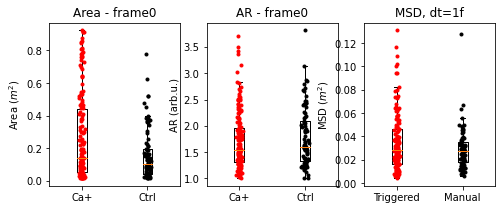

In [13]:
x_ca = np.random.normal(1, 0.02, size=len(f0_areas_ca))
x_ctrl = np.random.normal(2, 0.02, size=len(f0_areas_ctrl))

fig1, axs = plt.subplots(1,3,figsize=[8,3])

axs[0].title.set_text('Area - frame0')
axs[0].boxplot(f0_areas_ca, positions=[1], showfliers=False, labels={'Ca+'})
axs[0].plot(x_ca, f0_areas_ca, 'r.')
axs[0].boxplot(f0_areas_ctrl, positions=[2], showfliers=False, labels={'Ctrl'})
axs[0].plot(x_ctrl, f0_areas_ctrl, 'k.')
axs[0].set_ylabel('Area ($m^2$)')

axs[1].title.set_text('AR - frame0')
axs[1].boxplot(f0_ars_ca, positions=[1], showfliers=False, labels={'Ca+'})
axs[1].plot(x_ca, f0_ars_ca, 'r.')
axs[1].boxplot(f0_ars_ctrl, positions=[2], showfliers=False, labels={'Ctrl'})
axs[1].plot(x_ctrl, f0_ars_ctrl, 'k.')
axs[1].set_ylabel('AR (arb.u.)')

x_ca = np.random.normal(1, 0.02, size=len(msds_ca))
x_ctrl = np.random.normal(2, 0.02, size=len(msds_ctrl))

axs[2].title.set_text('MSD, dt=1f')
axs[2].boxplot(msds_ca[~np.isnan(msds_ca)], positions=[1], showfliers=False, labels={'Triggered'})
axs[2].plot(x_ca, msds_ca, 'r.')
axs[2].boxplot(msds_ctrl[~np.isnan(msds_ctrl)], positions=[2], showfliers=False, labels={'Manual'})
axs[2].plot(x_ctrl, msds_ctrl, 'k.')
axs[2].set_ylabel('MSD ($m^2$)')

save = False
if save:
    savefolder = 'example_data'
    #fig1.savefig(os.path.join(savefolder, 'synaptotagmin-MSD-dt1f-Area-AR.svg'))
    fig1.savefig(os.path.join(savefolder, 'synaptotagmin-MSD-dt1f-Area-AR-24Hz.tif'))
    
print(np.mean(f0_areas_ca))
print(np.std(f0_areas_ca))
print(np.mean(f0_areas_ctrl))
print(np.std(f0_areas_ctrl))
print(np.mean(f0_ars_ca))
print(np.std(f0_ars_ca))
print(np.mean(f0_ars_ctrl))
print(np.std(f0_ars_ctrl))

print(np.mean(msds_ca[~np.isnan(msds_ca)]))
print(np.std(msds_ca[~np.isnan(msds_ca)]))
print(np.mean(msds_ctrl[~np.isnan(msds_ctrl)]))
print(np.std(msds_ctrl[~np.isnan(msds_ctrl)]))

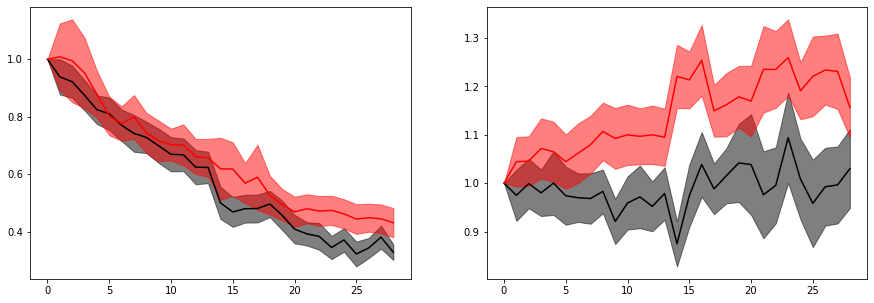

In [14]:
# Area curves
max_len = 0
for arr in area_curves_ctrl:
    if len(arr) > max_len:
        max_len = len(arr)
for idx, arr in enumerate(area_curves_ctrl):
    if len(arr) < max_len:
        add = np.empty(max_len - len(arr))
        add[:] = np.nan
        arr_update = np.concatenate([arr, add])
    else:
        arr_update = arr
    arr_update = arr_update / arr_update[0]
    area_curves_ctrl[idx] = arr_update
        
max_len = 0
for arr in area_curves_ca:
    if len(arr) > max_len:
        max_len = len(arr)
for idx, arr in enumerate(area_curves_ca):
    if len(arr) < max_len:
        add = np.empty(max_len - len(arr))
        add[:] = np.nan
        arr_update = np.concatenate([arr, add])
    else:
        arr_update = arr
    arr_update = arr_update / arr_update[0]
    area_curves_ca[idx] = arr_update
    
# AR curves
max_len = 0
for arr in ar_curves_ctrl:
    if len(arr) > max_len:
        max_len = len(arr)
for idx, arr in enumerate(ar_curves_ctrl):
    if len(arr) < max_len:
        add = np.empty(max_len - len(arr))
        add[:] = np.nan
        arr_update = np.concatenate([arr, add])
    else:
        arr_update = arr
    arr_update = arr_update / arr_update[0]
    ar_curves_ctrl[idx] = arr_update
        
max_len = 0
for arr in ar_curves_ca:
    if len(arr) > max_len:
        max_len = len(arr)
for idx, arr in enumerate(ar_curves_ca):
    if len(arr) < max_len:
        add = np.empty(max_len - len(arr))
        add[:] = np.nan
        arr_update = np.concatenate([arr, add])
    else:
        arr_update = arr
    arr_update = arr_update / arr_update[0]
    ar_curves_ca[idx] = arr_update
    
    

fig, axs = plt.subplots(1,2,figsize=[15,5])

axs[0].plot(np.nanmean(area_curves_ctrl, axis=0),'black')
axs[0].fill_between(range(len(area_curves_ctrl[0])),np.nanmean(area_curves_ctrl, axis=0)-np.nanstd(area_curves_ctrl, axis=0)/np.sqrt(14),np.nanmean(area_curves_ctrl, axis=0)+np.nanstd(area_curves_ctrl, axis=0)/np.sqrt(14),color='black',alpha=0.5)
axs[0].plot(np.nanmean(area_curves_ca, axis=0),'red')
axs[0].fill_between(range(len(area_curves_ca[0])),np.nanmean(area_curves_ca, axis=0)-np.nanstd(area_curves_ca, axis=0)/np.sqrt(23),np.nanmean(area_curves_ca, axis=0)+np.nanstd(area_curves_ca, axis=0)/np.sqrt(23),color='red',alpha=0.5)

axs[1].plot(np.nanmean(ar_curves_ctrl, axis=0),'black')
axs[1].fill_between(range(len(ar_curves_ctrl[0])),np.nanmean(ar_curves_ctrl, axis=0)-np.nanstd(ar_curves_ctrl, axis=0)/np.sqrt(14),np.nanmean(ar_curves_ctrl, axis=0)+np.nanstd(ar_curves_ctrl, axis=0)/np.sqrt(14),color='black',alpha=0.5)
axs[1].plot(np.nanmean(ar_curves_ca, axis=0),'red')
axs[1].fill_between(range(len(ar_curves_ca[0])),np.nanmean(ar_curves_ca, axis=0)-np.nanstd(ar_curves_ca, axis=0)/np.sqrt(23),np.nanmean(ar_curves_ca, axis=0)+np.nanstd(ar_curves_ca, axis=0)/np.sqrt(23),color='red',alpha=0.5)

In [15]:
import scipy.stats as scst
print(scst.kstest(msds_ca[~np.isnan(msds_ca)], msds_ctrl[~np.isnan(msds_ctrl)]))
print(scst.ttest_ind(msds_ca[~np.isnan(msds_ca)], msds_ctrl[~np.isnan(msds_ctrl)]))
print(scst.kstest(f0_areas_ca,f0_areas_ctrl))
print(scst.ttest_ind(f0_areas_ca,f0_areas_ctrl))
print(scst.kstest(f0_ars_ca,f0_ars_ctrl))
print(scst.ttest_ind(f0_ars_ca,f0_ars_ctrl))

KstestResult(statistic=0.16787941787941787, pvalue=0.09744487331398366)
Ttest_indResult(statistic=1.7495193492761323, pvalue=0.0815707585310402)
KstestResult(statistic=0.2096927033978611, pvalue=0.010039689625631065)
Ttest_indResult(statistic=3.6704865483981775, pvalue=0.0002952635054294318)
KstestResult(statistic=0.1404494382022472, pvalue=0.18078609388204447)
Ttest_indResult(statistic=-0.8580173230802842, pvalue=0.3916949960954388)


KstestResult(statistic=0.13581124757595345, pvalue=0.20049133601116587)


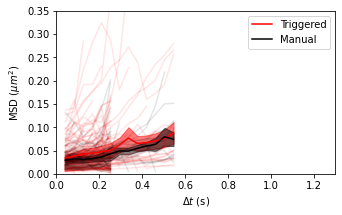

In [16]:
msds_time_ca_len = []
for arr in msds_time_ca:
    arr[0] = np.nan
    arr_len = len(arr)
    nan_arr = np.empty(30-arr_len)*np.nan
    msds_time_ca_len.append(np.concatenate([arr,nan_arr]))
    
msds_time_ctrl_len = []
for arr in msds_time_ctrl:
    arr[0] = np.nan
    arr_len = len(arr)
    nan_arr = np.empty(30-arr_len)*np.nan
    msds_time_ctrl_len.append(np.concatenate([arr,nan_arr]))
    
    
mean_ca = np.nanmean(msds_time_ca_len,axis=0)
mean_ctrl = np.nanmean(msds_time_ctrl_len,axis=0)
std_ca = np.nanstd(msds_time_ca_len,axis=0)
std_ctrl = np.nanstd(msds_time_ctrl_len,axis=0)
sem_ca = std_ca/np.sqrt(27)
sem_ctrl = std_ctrl/np.sqrt(14)

# plotting
x_ca = np.arange(len(mean_ca))*dt
x_ctrl = np.arange(len(mean_ctrl))*dt

fig1 = plt.figure(figsize=(5,3))
i = True
for arr in msds_time_ca_len:
    if i==True:
        plt.plot(np.arange(len(arr))*dt,arr,'red',alpha=0.1)#,label='Triggered')
        i = False
    else:
        plt.plot(np.arange(len(arr))*dt,arr,'red',alpha=0.1)
i = True
for arr in msds_time_ctrl_len:
    if i==True:
        plt.plot(np.arange(len(arr))*dt,arr,'black',alpha=0.1)#,label='Manual')
        i = False
    else:
        plt.plot(np.arange(len(arr))*dt,arr,'black',alpha=0.1)
    
from scipy import stats
ca_lo, ca_hi = stats.norm.interval(0.83, loc=mean_ca, scale=sem_ca)
ctrl_lo, ctrl_hi = stats.norm.interval(0.83, loc=mean_ctrl, scale=sem_ctrl)
    
plt.plot(x_ca,mean_ca, 'red',label='Triggered')
plt.plot(x_ctrl,mean_ctrl, 'black',label='Manual')
#plt.fill_between(x_ca,mean_ca-sem_ca,mean_ca+sem_ca,color='red',alpha=0.5,label='Triggered, SEM')
plt.fill_between(x_ca,ca_lo,ca_hi,color='red',alpha=0.5)#,label='Triggered, SEM')
#plt.fill_between(x_ctrl,mean_ctrl-sem_ctrl,mean_ctrl+sem_ctrl,color='black',alpha=0.5,label='Manual, SEM')
plt.fill_between(x_ctrl,ctrl_lo,ctrl_hi,color='black',alpha=0.5)#,label='Manual, SEM')
plt.ylabel('MSD ($µm^2$)')
plt.xlabel('$\Delta t$ (s)')
plt.legend(loc='upper right')
plt.ylim([0,0.35])
plt.xlim([0,1.3])
#plt.legend({'Ca-triggered','Manual'},loc='upper left')

import scipy.stats as scst
print(scst.kstest(msds_ca, msds_ctrl))

save = False
if save:
    savefolder = 'example_data'
    fig1.savefig(os.path.join(savefolder, 'synaptotagmin-MSD-11hz-zoom.tiff'))
    #fig1.savefig(os.path.join(savefolder, 'synaptotagmin-MSD-cavsctrl.svg'))